In [1]:
# This notebook checks MNE functions for ECG and EOG detection
# Cropped data is used here (5 minutes only), tried on whole data - takes forever.


#Load data, make folders
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import mne
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
import configparser
import ancpbids
import plotly
import mpld3

from main_meg_qc import make_derivative_meg_qc, sanity_check, initial_stuff

from data_load_and_folders import load_meg_data, make_folders_meg, Epoch_meg
from RMSE_meq_qc import RMSE_meg_qc
from PSD_meg_qc import PSD_meg_qc
from Peaks_manual_meg_qc import PP_manual_meg_qc
from Peaks_auto_meg_qc import PP_auto_meg_qc
from ECG_meg_qc import ECG_meg_qc
from EOG_meg_qc import EOG_meg_qc
from universal_html_report import keep_fig_derivs, make_joined_report





Opening raw data file /Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds003483/sub-009/ses-1/meg/sub-009_ses-1_task-deduction_run-1_meg.fif...
    Range : 60000 ... 1255999 =     60.000 ...  1255.999 secs
Ready.
Stimulus channels detected: ['STI101', 'STI201', 'STI301']
9 events found
Event IDs: [2 4 8]
Trigger channel has a non-zero initial value of 3840 (consider using initial_event=True to detect this event)
Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
Loading data for 9 events and 1201 original time points ...
0 bad epochs dropped
Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
Loading data for 9 events and 1201 original time points ...
0 bad epochs dropped


Magnetometers
  
Average absolute power per band:
delta 2.5437973070550183e-26
theta 1.3639856940103193e-26
alpha 3.211810764849161e-26
beta 2.5221025679142266e-26
gamma 1.2668665027936868e-26
  
Average relative power per band:
delta 0.24507960730803682
theta 0.12649406942852515
alpha 0.26440776546747746
beta 0.23022214655649956
gamma 0.13567544758519798
  
Average power/freq per band:
delta 6.359493267637546e-27
theta 2.727971388020639e-27
alpha 6.423621529698322e-27
beta 1.3274224041653824e-27
gamma 1.7843190180192773e-28


Gradiometers
  
Average absolute power per band:
delta 1.0130971126447134e-23
theta 6.101908902629596e-24
alpha 1.4569939224503134e-23
beta 1.2059597718988196e-23
gamma 7.241532135495029e-24
  
Average relative power per band:
delta 0.2163314063719931
theta 0.12250932655828814
alpha 0.2532582314678807
beta 0.2326874576364519
gamma 0.17659800109413648
  
Average power/freq per band:
delta 2.5327427816117836e-24
theta 1.2203817805259193e-24
alpha 2.9139878449006266e-24
beta 6.347156694204315e-25
gamma 1.0199341035908492e-25


Using EOG channel: EOG061
EOG channel index for this subject is: [306]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 384 significant peaks
Number of EOG events detected: 384
Using EOG channel: EOG061
EOG channel index for this subject is: [306]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
De

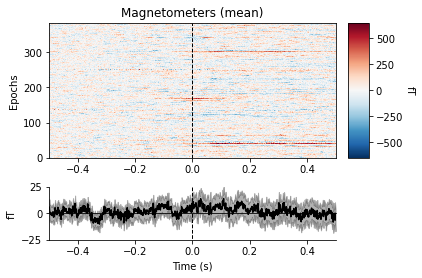

No projector specified for this dataset. Please consider the method self.add_proj.


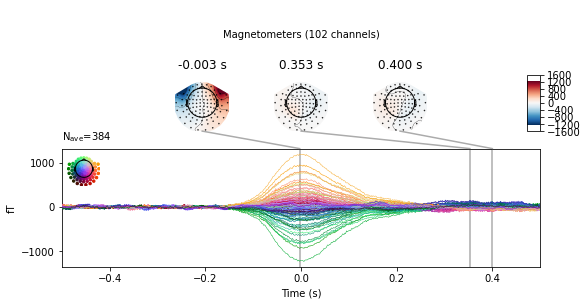

Not setting metadata
384 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


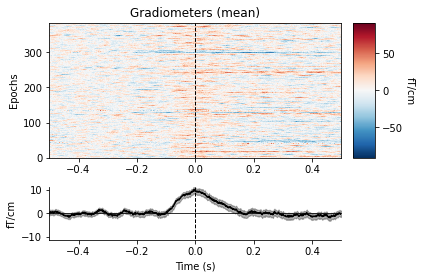

No projector specified for this dataset. Please consider the method self.add_proj.


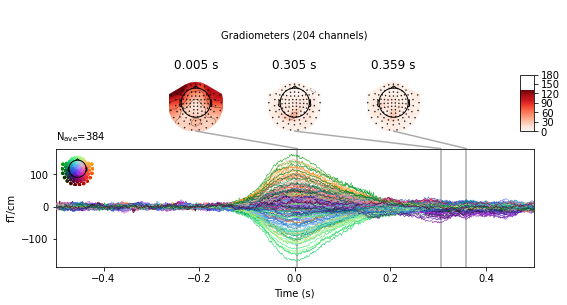

/Users/jenya/opt/anaconda3/envs/mne_new/lib/python3.9/site-packages/mpld3/mplexporter/exporter.py:84: UserWarning:

Blended transforms not yet supported. Zoom behavior may not work as expected.



In [2]:
#%% TRY TO SAVE DERIVATIVE FROM BIDS DATASET HERE:

config_file_name = 'settings.ini'
make_derivative_meg_qc(config_file_name)


In [ ]:

from universal_plots import add_output_format
from universal_html_report import keep_fig_derivs

html_string='''<html>
            #     <head>
            #     <title>HTML File</title>
            #     </head>
            #     <body>
            #     <h1>stuff</h1>
            #     <p>Example stuff</p>
            #     </body>
            #     </html>'''
all_derivs=[(html_string, 'stuff_report', None, 'report')]
all_derivs += [(html_string, 'stuff_report2', None, 'plotly')]

for d in all_derivs:
    if d[3] == 'plotly': #or d[3] == 'matplotlib':
        print(d[3])

all_fig_derivs = keep_fig_derivs(all_derivs)

print(all_fig_derivs)

In [ ]:
# Other useful ancp stuff:

config = configparser.ConfigParser()
config.read('settings.ini')

default_direct = config['DEFAULT']['data_directory']
dataset_path = ancpbids.utils.fetch_dataset(default_direct)

from ancpbids import BIDSLayout
layout = BIDSLayout(dataset_path)

list_of_fifs = layout.get(suffix='meg', extension='.fif', return_type='filename')

list_of_subs = layout.get_subjects()


list_of_entities = layout.get_entities()
print(list_of_entities)

In [ ]:
#TRY SEPARATE FUNCS HERE

config = configparser.ConfigParser()
config.read('settings.ini')
data_file = '/Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds003483/sub-009/ses-1/meg/sub-009_ses-1_task-deduction_run-1_meg.fif'
dict_of_dfs_epoch, epochs_mg, channels, raw_bandpass, raw_filtered_resampled, raw_cropped, raw = initial_stuff(config, data_file)
m_or_g_chosen = ['mags']
sid='009'
#dfs_ptp_amlitude_annot, bad_channels, amplit_annot_with_ch_names = PP_auto_meg_qc(sid, config, channels, raw, m_or_g_chosen)

#out_with_name_and_format = RMSE_meg_qc(sid, config, channels, dict_of_dfs_epoch, raw_filtered_resampled, m_or_g_chosen)

#out_with_name_and_format = PP_manual_meg_qc(sid, config, channels, dict_of_dfs_epoch, raw_filtered_resampled, m_or_g_chosen)

#out_with_name_and_format = PSD_meg_qc(sid, config, channels, raw_filtered_resampled, m_or_g_chosen)

#out_with_name_and_format = ECG_meg_qc(config, raw, m_or_g_chosen)

out_with_name_and_format = EOG_meg_qc(config, raw, m_or_g_chosen)

#out_with_name_and_format, bad_channels = PP_auto_meg_qc(sid, config, channels, raw_filtered_resampled, m_or_g_chosen)

# psd_section = config['PSD']
# freq_min = psd_section.getfloat('freq_min') 
# freq_max = psd_section.getfloat('freq_max') 
# mean_power_per_band_needed = psd_section.getboolean('mean_power_per_band_needed')
# n_fft = psd_section.getint('n_fft')
# n_per_seg = psd_section.getint('n_per_seg')

# m_or_g='mags'
# fig, fig_desc, fig_path, dfs_with_name = Power_of_freq_meg(ch_names=channels[m_or_g], m_or_g = m_or_g, freqs = freqs[m_or_g], psds = psds[m_or_g], mean_power_per_band_needed = mean_power_per_band_needed, plotflag = True, sid = sid)

#deriv_with_name_and_format = PSD_meg_qc(sid, config, channels, raw_filtered_resampled, m_or_g_chosen)


#figs = ECG_meg_qc(config, raw, m_or_g_chosen)

print(out_with_name_and_format)

In [ ]:
# out_with_name_and_format[0].convert_fig_to_html()
from universal_plots import QC_derivative
dr = QC_derivative('001', 'mean_EC_epoch', None, '')
# dr_html = dr.convert_fig_to_html()
# l=["a"]

# if dr_html is not None:

#     l += dr_html
    
# print(l)

sec = dr.get_section()
print(sec)


In [ ]:
print(figs)
all_fig_derivs = figs
figures_report = {}
for x in range(0, len(all_fig_derivs)):
    if all_fig_derivs[x][3]=='plotly':
        figures_report["f{0}".format(x)] = plotly.io.to_html(all_fig_derivs[x][0])
    elif all_fig_derivs[x][3]=='matplotlib':
        figures_report["f{0}".format(x)] = mpld3.fig_to_html(all_fig_derivs[x][0]);

print(figures_report)

In [ ]:

import mpld3

html_fig=mpld3.fig_to_html(figs[0][0])
print(html_fig)



# file = open('matpl_fig.html', "w")
# file.write(html_fig)
# file.close()

In [ ]:
html_string = '''
<!doctype html>
<html>
    <head>
        <meta charset="UTF-8">
        <title>MEG QC: Frequency spectrum Report</title>
        <style>body{ margin:0 100;}</style>
    </head>
    
    <body style="font-family: Arial">
        <center>
        <h1>MEG data quality analysis report</h1>
        <br></br>
        <!-- *** Section 1 *** --->
        <h2>Frequency spectrum per channel</h2>
        ''' + html_fig + '''
        <p>graph description...</p>
        </center>
    
    </body>
</html>'''

with open('report_trial.html', 'w', encoding = 'utf8') as f:
    f.write(html_string)

In [ ]:
#config = configparser.ConfigParser()
#config.read('settings.ini')

#data_file = '/Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds000117/sub-01/ses-meg/meg/sub-01_ses-meg_task-facerecognition_run-01_meg.fif'
# file does not start with a file id tag

#data_file = '/Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds003392/sub-01/meg/sub-01_task-localizer_meg.fif'
# SSS frilter. need to allow maxshiled.

#data_file ='/Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds003694/sub-01/meg/sub-01_task-MEM_run-01_meg.fif'
#raw = mne.io.read_raw_fif(data_file, on_split_missing='ignore')


#dict_of_dfs_epoch, epochs_mg, channels, raw_bandpass, raw_filtered_resampled, raw_cropped, raw = initial_stuff(config, data_file)

#data_file ='/Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds003922/sub-Mp150285/ses-01/meg/sub-Mp150285_ses-01_acq-crosstalk_meg.fif'
#Could not find measurement data: how many in this set, which subjects?


#data_file ='/Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds004229/sub-102/meg/sub-102_task-amnoise_meg.fif'
#SSS filter
#raw = mne.io.read_raw_fif(data_file, allow_maxshield=True)


data_dir ='/Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/not fitting no fif/ds000246/sub-0001/meg/sub-0001_task-AEF_run-01_meg.ds'
raw = mne.io.read_raw_ctf(data_dir)


In [ ]:
raw
# reference channels for ctf systems already implemented (subtracted), is this done automatically by the ctf systems?